Plot Twbdmax time series (Fig. 1a)

In [1]:
import sys
import os
import argparse
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from config import *
from CP4.treat_max.a_make_dmax_proc_var import load_proc_var_dmax
from CP4.treat_max.b_compute_running_perc_dmax_proc_var import load_proc_var_dmax_roll_quantile

Done
Done
Done


In [12]:
ds='CP4A'
res=4
var='twb'
window=6
y0=1997
y1=2006
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
q_thresh=0.95
t_thresh=26.
qwindow=31
n_days=3
lat_range=[9., 18.]
lon_range=[-8., 10.]
lat_pt=13.5
lon_pt=2.2
year=1998
month=6
flabel='a'

In [7]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

lat_min = lat_range[0]
lat_max = lat_range[1]
assert lat_min < lat_max, "incorrect latitude range"
lon_min = lon_range[0]
lon_max = lon_range[1]
assert lon_min < lon_max, "incorrect longitude range"

In [13]:
#~ Get data

dmax = load_proc_var_dmax(ds, res, var, window, y0, y1, months, lat_range, lon_range)
dmax_pt = dmax.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')

iyrs = dmax_pt.groupby('time.year').groups
dmax_pt_yr = dmax_pt.isel(time=iyrs[year])
dmax_pt_yr_ = dmax_pt_yr[15:-15]

imths = dmax_pt_yr.groupby('time.month').groups
dmax_pt_mth = dmax_pt_yr.isel(time=imths[month])

qdata = load_proc_var_dmax_roll_quantile(ds, res, var, q_thresh, qwindow, window, y0, y1, months, lat_range, lon_range)
qdata_pt = qdata.sel(latitude=lat_pt, longitude=lon_pt, method='nearest')

idayq = (months[0]-1) * 30 + int(qwindow/2)+1  # index of the first day of quantile data

# get q data for study month
iday0 = (month-1)*30+1
iday1 = iday0+30
i0 = iday0 - idayq
i1 = iday1 - idayq
qdata_pt_mth = qdata_pt.isel(days=slice(i0, i1))

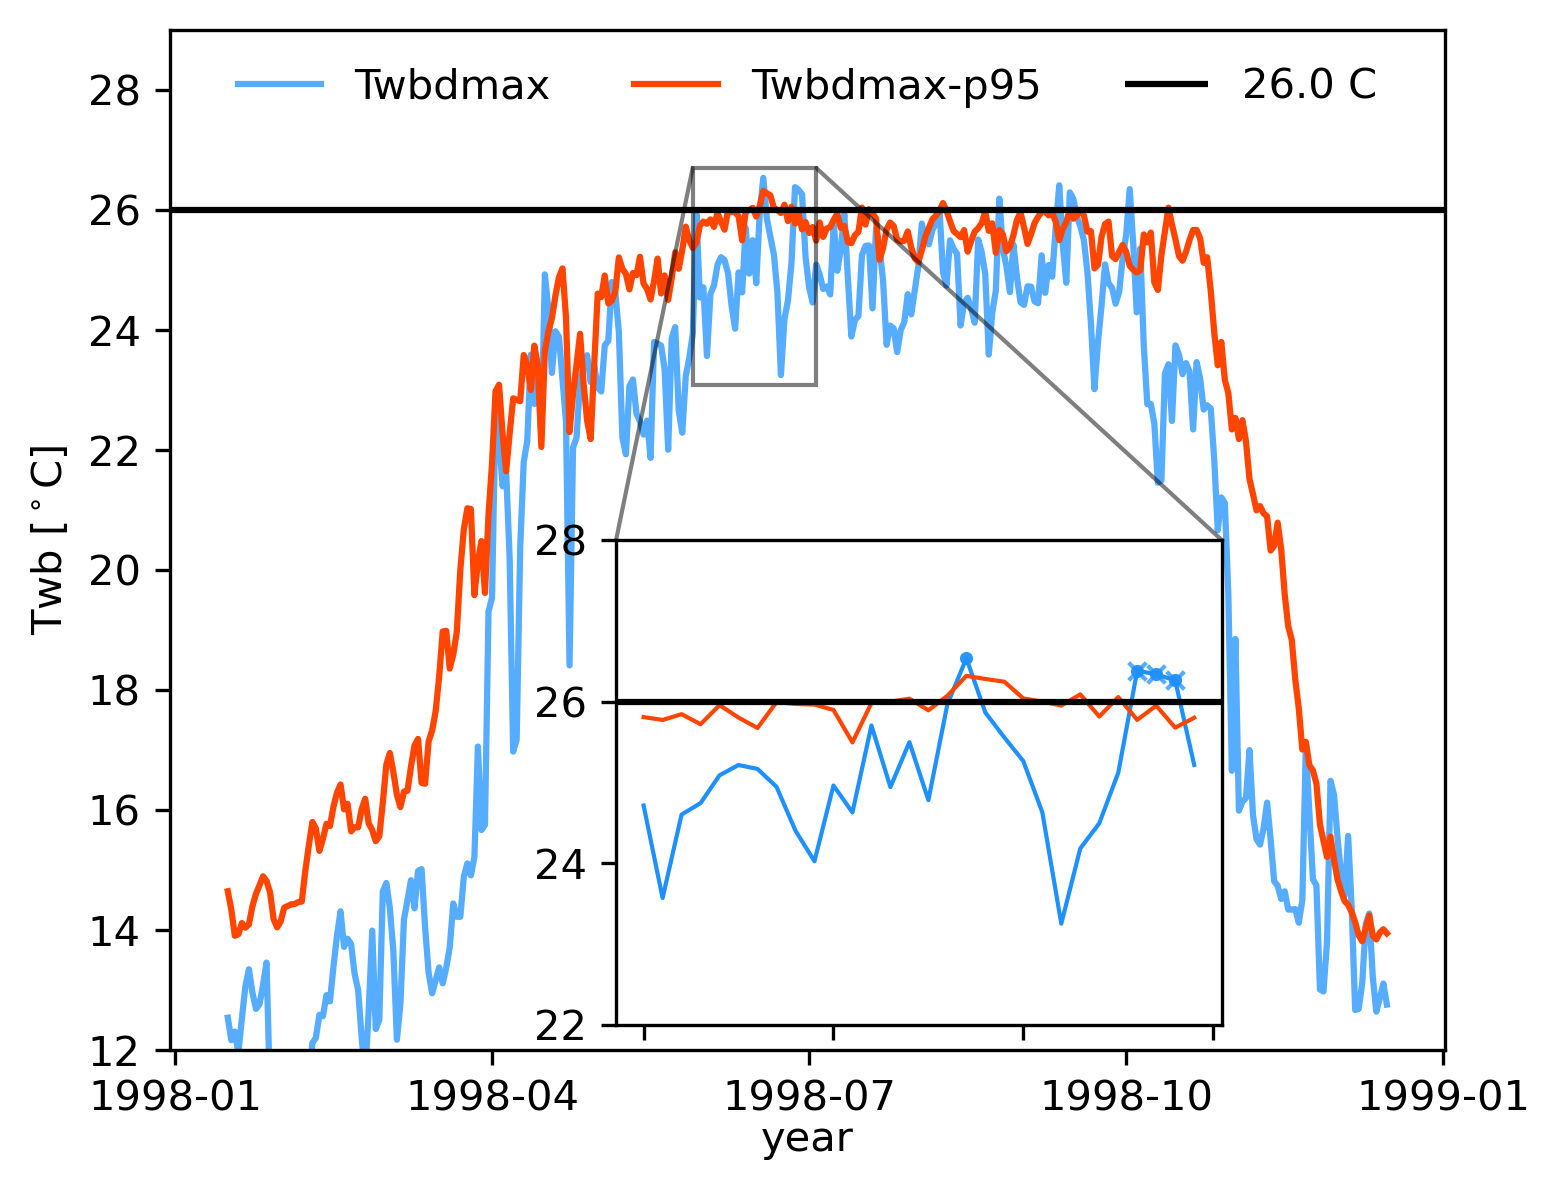

In [16]:
#~ Plot

fig, ax = plt.subplots(dpi=300)

plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)

p = dmax_pt_yr_.plot(color='dodgerblue', alpha=0.75, label='Twbdmax')
ax.plot(dmax_pt_yr_.time.values, qdata_pt.values, color='orangered', label='Twbdmax-p95')  # qdata_pt_va>

xlims = ax.get_xlim()

ax.hlines(t_thresh, xlims[0], xlims[1], color='k', label='{0} C'.format(t_thresh))

#ax.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax.transAxes)

ax.set_xlim(xlims)
ax.set_xlabel('year', labelpad=0.2)
ax.set_ylim(12., 29.)
ax.set_ylabel('Twb [$^\circ$C]')


axins = ax.inset_axes([0.35, 0.025, 0.475, 0.475])

dmax_pt_mth.plot(color='dodgerblue', ax=axins, lw=1.)

xlims_inset = axins.get_xlim()
axins.plot(dmax_pt_mth.time.values, qdata_pt_mth.values, lw=1., color='orangered')
axins.hlines(t_thresh, xlims_inset[0], xlims_inset[1], color='k', label='{0} C'.format(t_thresh))

ax.indicate_inset_zoom(axins, edgecolor="black")
axins.set_xlim(xlims_inset)
axins.set_xlabel('')
axins.set_xticklabels([])

axins.set_ylim(22., 28.)
axins.set_title('')

# Identify hot / humid days
ids_good_rel = np.where(dmax_pt_mth.values >= qdata_pt_mth.values)[0]
ids_good_abs = np.where(dmax_pt_mth.values >= t_thresh)[0]

ids_good = [i for i in ids_good_rel if i in ids_good_abs]

axins.scatter(dmax_pt_mth.time.values[ids_good][1:], dmax_pt_mth.values[ids_good][1:], marker='o', c='dodgerblue', alpha=0.95, s=10., linewidths=0., zorder=100)
axins.scatter(dmax_pt_mth.time.values[ids_good][1:], dmax_pt_mth.values[ids_good][1:], marker='x', c='dodgerblue', alpha=0.75, s=18., linewidths=1., zorder=100)
axins.scatter(dmax_pt_mth.time.values[ids_good][0], dmax_pt_mth.values[ids_good][0], marker='o', c='dodgerblue', alpha=0.95, s=10., linewidths=0., zorder=100)

ax.set_title('')

ax.legend(ncol=3, loc='upper center', frameon=False)

fig.set_size_inches(5., 4.)